In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Extract HRRR data using Unidata's Siphon package

In [2]:
# Resolve the latest HRRR dataset
from siphon.catalog import get_latest_access_url

hrrr_catalog = "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml"
latest_hrrr_ncss = get_latest_access_url(hrrr_catalog, "NetcdfSubset")

# Set up access via NCSS
from siphon.ncss import NCSS
ncss = NCSS(latest_hrrr_ncss)

# Create a query to ask for all times in netcdf4 format for
# the Temperature_surface variable, with a bounding box
query = ncss.query()

In [3]:
query.all_times().accept('netcdf4').variables('Temperature_height_above_ground')
query.lonlat_box(north=43, south=41, east=-87, west=-91)

# Get the raw bytes and write to a file.
data = ncss.get_data_raw(query)
with open('test.nc', 'wb') as outf:
    outf.write(data)

In [4]:
import netCDF4
nc = netCDF4.Dataset('test.nc')

## Try reading extracted data with Xarray

In [4]:
import xarray

In [5]:
nc = xarray.open_dataset('test.nc')

In [5]:
nc

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Originating_or_generating_Center: US National Weather Service, National Centres for Environmental Prediction (NCEP)
    Originating_or_generating_Subcenter: 0
    GRIB_table_version: 2,1
    Type_of_generating_process: Forecast
    Conventions: CF-1.6
    history: Read using CDM IOSP GribCollection v3
    featureType: GRID
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = /data/ldm/pub/native/grid/NCEP/HRRR/CONUS_2p5km/HRRR_CONUS_2p5km_20160302_0300.grib2.ncx3#LambertConformal_1377X2145-38p22N-95p43W; Translation Date = 2016-03-02T04:56:04.910Z
    geospatial_lat_min: 40.8539282623
    geospatial_lat_max: 43.1447053859
    geospatial_lon_min: -91.0951665655
    geospatial_lon_max: -86.8356986947
    dimensions(sizes): time(16), height_above_ground1(1), y(99), x(141)
    variables(dimensions): float32 Temperature_height_above_ground(time,height_above

In [6]:
var='Temperature_height_above_ground'
ncvar = nc[var]
ncvar

<type 'netCDF4._netCDF4.Variable'>
float32 Temperature_height_above_ground(time, height_above_ground1, y, x)
    long_name: Temperature @ Specified height level above ground
    units: K
    abbreviation: TMP
    missing_value: nan
    grid_mapping: LambertConformal_Projection
    coordinates: time height_above_ground1 y x 
    Grib_Variable_Id: VAR_0-0-0_L103
    Grib2_Parameter: [0 0 0]
    Grib2_Parameter_Discipline: Meteorological products
    Grib2_Parameter_Category: Temperature
    Grib2_Parameter_Name: Temperature
    Grib2_Level_Type: Specified height level above ground
    Grib2_Generating_Process_Type: Forecast
unlimited dimensions: 
current shape = (16, 1, 99, 141)
filling on, default _FillValue of 9.96920996839e+36 used

In [7]:
grid = nc[ncvar.grid_mapping]
grid

<type 'netCDF4._netCDF4.Variable'>
int32 LambertConformal_Projection()
    grid_mapping_name: lambert_conformal_conic
    latitude_of_projection_origin: 25.0
    longitude_of_central_meridian: 265.0
    standard_parallel: 25.0
    earth_radius: 6371229.0
    _CoordinateTransformType: Projection
    _CoordinateAxisTypes: GeoX GeoY
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

In [8]:
lon0 = grid.longitude_of_central_meridian
lat0 = grid.latitude_of_projection_origin
lat1 = grid.standard_parallel
earth_radius = grid.earth_radius

## Try plotting the LambertConformal data with Cartopy

In [9]:
import cartopy
import cartopy.crs as ccrs

In [13]:
#cartopy wants meters, not km
x = nc['x'][:]*1000.
y = nc['y'][:]*1000.

In [14]:
#globe = ccrs.Globe(ellipse='WGS84') #default
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)

crs = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, 
                            standard_parallels=(lat0,lat1), globe=globe)

In [13]:
print(ncvar.x.data.shape)
print(ncvar.y.data.shape)
print(ncvar.data.shape)

(365,)
(240,)
(16, 1, 240, 365)


In [15]:
# find the correct time dimension name
for d in ncvar.dims:
    if "time" in d: 
        timevar = d
nc[timevar].data[6]

AttributeError: NetCDF: Attribute not found

C:\Users\LLJ116\Miniconda2\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


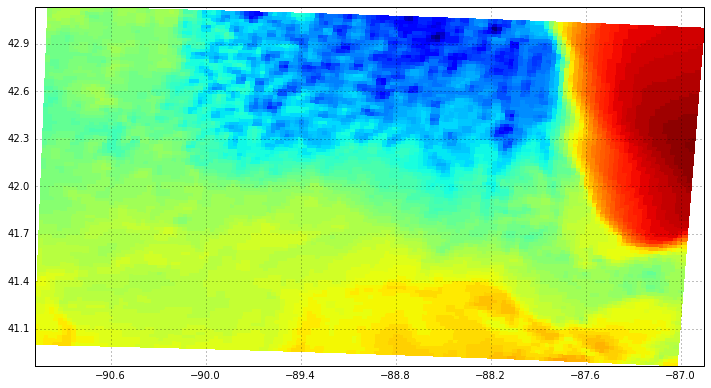

In [16]:
istep = 6
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(x,y,ncvar[istep,::].data.squeeze(), transform=crs,zorder=0)
ax.coastlines(resolution='10m',color='black',zorder=1)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#plt.title(nc[timevar].data[istep]);